In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plot_config
plot_config.set_config()

In [2]:
experiment = 'powersupply'
name_caps = 'PowerSupply'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


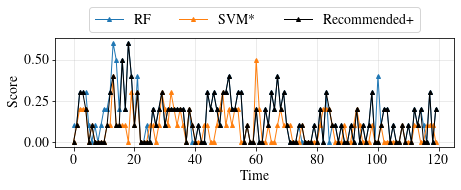

In [3]:
rf_score = load('../data/'+experiment+'/score_rf.joblib')[:120]
svm_score = load('../data/'+experiment+'/score_svm.joblib')[:120]
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))[:120]
fig = plt.gcf()
fig.set_size_inches(7.14, 2)
plt.plot(rf_score, '^-', label='RF')
plt.plot(svm_score, '^-', label='SVM*')
plt.plot(score_recommended, 'k^-', label='Recommended+')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True)
plt.savefig(experiment+'_tscores.pdf', bbox_inches='tight')

In [4]:
t_importance = load('../data/'+experiment+'/importance.joblib')
t_fname = load('../data/'+experiment+'/fnames.joblib')[:-1]
dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-15:]
importance = [k for k,v in dic]
fname = [v for k,v in dic]
pos = np.arange(len(importance))

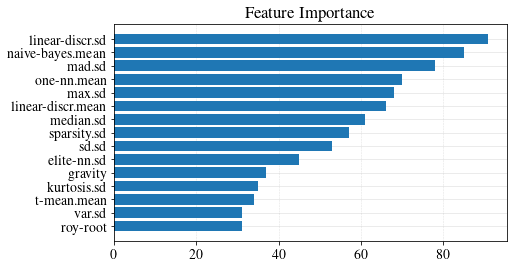

In [5]:
fig, ax1 = plt.subplots()
fig.subplots_adjust(left=0.115, right=0.88)
ax1.set_title('Feature Importance')
ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
rects = plt.barh(pos, importance,
         align='center',
         tick_label=[x.replace('_','-') for x in fname])
fig = plt.gcf()
fig.set_size_inches(7.14, 4)
plt.savefig(experiment+'_fi.pdf', bbox_inches='tight')

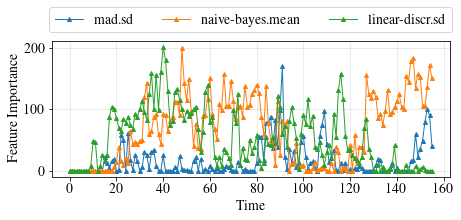

In [6]:
tfi = load('../data/'+experiment+'_ninc/tfi.joblib')
topfname = fname[-3:]
tfi = pd.DataFrame(tfi, columns=t_fname)[topfname]
tfi.rename(columns={x:x.replace('_','-') for x in topfname}, inplace=True)
ax = tfi.plot(style='^-')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3, fancybox=True)
fig = plt.gcf()
fig.set_size_inches(7.14, 2.5)
plt.savefig(experiment+'_timefi.pdf', bbox_inches='tight')

In [7]:
arange = 1000
difference = np.array(load('../data/'+experiment+'/difference.joblib'))
difference_ninc = np.array(load('../data/'+experiment+'_ninc/difference.joblib'))
cum = np.cumsum(difference)[:arange]
cum_ninc = np.cumsum(difference_ninc)[:arange]
x = np.arange(arange)

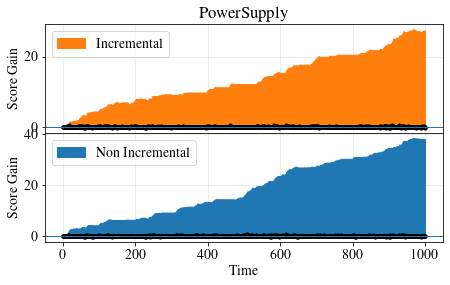

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), sharex=True, gridspec_kw={'hspace': 0})

ax1.fill_between(x, cum, 0, color='C1', label='Incremental')
ax1.scatter(x, difference[:arange], s=10, c='black')
ax1.set_title(name_caps)
ax1.axhline(0)
ax1.legend(loc='upper left')
ax1.set_ylabel('Score Gain')

ax2.fill_between(x, cum_ninc, 0, color='C0', label='Non Incremental')
ax2.scatter(x, difference_ninc[:arange], s=10, c='black')
ax2.axhline(0)
ax2.legend(loc='upper left')
ax2.set_ylabel('Score Gain')
ax2.set_xlabel('Time')

fig = plt.gcf()
fig.set_size_inches(7.14, 4)
plt.savefig(experiment+'_cumsum.pdf', bbox_inches='tight')

In [9]:
print(cum[-10:])

[27.  27.2 27.2 27.3 27.2 27.1 27.3 27.4 27.4 27.2]


In [10]:
with open('../'+experiment.replace('_','-')+'.output') as fin:
    print(fin.read())

[GENERATE METAFEATURE]
Frequency statistics in metabase:
	Pipeline                 0.535
	RandomForestClassifier   0.465
[OFFLINE LEARNING]
Kappa:    0.120+-0.299
GMean:    0.472+-0.255
Accuracy: 0.544+-0.177
[ONLINE LEARNING]
Kappa:  0.007062282535625353
GMean:  0.4677516077231409
Accuracy:  0.5086042065009561
              precision    recall  f1-score   support

           0       0.52      0.69      0.59       806
           1       0.49      0.32      0.39       763

    accuracy                           0.51      1569
   macro avg       0.50      0.50      0.49      1569
weighted avg       0.50      0.51      0.49      1569

                   pre       rec       spe        f1       geo       iba       sup

          0       0.52      0.69      0.32      0.59      0.47      0.23       806
          1       0.49      0.32      0.69      0.39      0.47      0.21       763

avg / total       0.50      0.51      0.50      0.49      0.47      0.22      1569



In [11]:
metadf = load('../data/'+experiment+'/metadf.joblib')
best = np.array(load('../data/'+experiment+'/best.joblib'))
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))
score_default = np.array(load('../data/'+experiment+'/score_def.joblib'))


score_recommended_ninc = np.array(load('../data/'+experiment+'_ninc/score_reco.joblib'))
score_default_ninc = np.array(load('../data/'+experiment+'_ninc/score_def.joblib'))

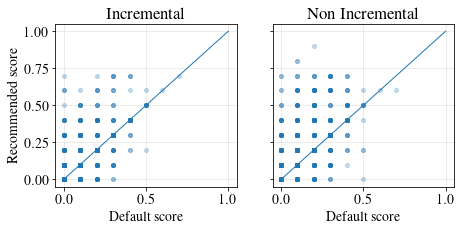

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax1.scatter(score_default, score_recommended, alpha=.25)
ax1.set_ylabel('Recommended score')
ax1.set_title('Incremental')
ax1.set_xlabel('Default score')
ax1.plot([0,1])

ax2.scatter(score_default_ninc, score_recommended_ninc, alpha=.25)
ax2.set_title('Non Incremental')
ax2.set_xlabel('Default score')
ax2.plot([0,1])

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_score.pdf', bbox_inches='tight')

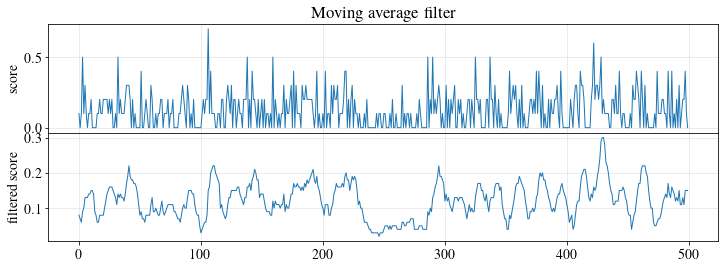

In [13]:
window_score = 500
N = 10
n_feats = 5
sorted_feats = np.argsort(t_importance)[::-1]
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), sharex=True, gridspec_kw={'hspace': 0})
ax1.plot(score_default[-window_score:])
moving_avg = np.convolve(score_default[-(window_score+N-1):], np.ones((N,))/N, mode='valid')
ax2.plot(moving_avg)
ax1.set_title('Moving average filter')
ax1.set_ylabel('score')
ax2.set_ylabel('filtered score')
plt.savefig(experiment+'_smovingavg.pdf', bbox_inches='tight')